In [32]:
from sklearn.utils import resample
import nltk
from wordcloud import WordCloud


## Importing data

In [5]:
import pandas as pd
import numpy as np
data = pd.read_csv('E:\\Coding\\MachineLearning\\CSVFile\\New_Delhi_reviews.csv')

## Data Analysis

Let’s start the data analysis by checking for the null values in the data.

In [6]:
data.isnull().sum()

rating_review    0
review_full      2
dtype: int64

Let’s calculate the distribution of ratings in data.

rating_review
5    72390
4    50248
3    15936
2     4552
1     4455
Name: count, dtype: int64


<Axes: xlabel='rating_review'>

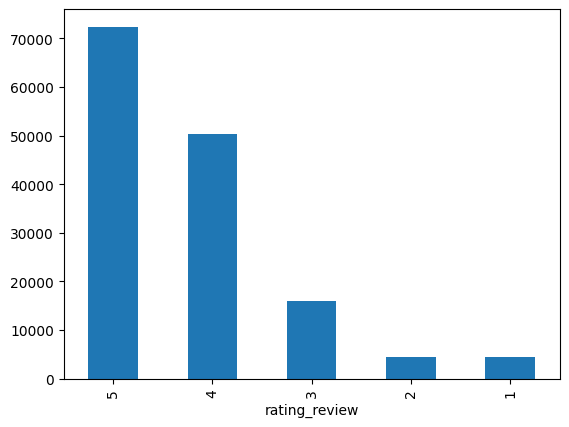

In [7]:
class_counts = data['rating_review'].value_counts()
print(class_counts)
class_counts.plot(kind='bar')

## Data Processing

Let’s start with calculating the average class count for rating.

In [8]:
avg_class_count = class_counts.mean()
print(avg_class_count)

29516.2


## Upsampling data

Upsampling data is a technique used to address class imbalance in a dataset, especially when one class (or label) is significantly underrepresented compared to others. In the context of machine learning classification tasks, class imbalance can lead to biased models that perform poorly on minority classes.

In [12]:
upsampled_data = pd.DataFrame()
for rating_review, count in class_counts.items():
    if count < avg_class_count:
        class_data = data[data['rating_review'] == rating_review]
        upsampled_class_data = resample(class_data, replace=True, n_samples=int(avg_class_count), random_state=42)
        upsampled_data = pd.concat([upsampled_data, upsampled_class_data])

## Downsampling data

Downsampling, also known as undersampling, is another technique used to address class imbalance in a dataset. Unlike upsampling, which involves increasing the number of instances in the minority class, downsampling aims to reduce the number of instances in the majority class to achieve a more balanced distribution.

In [14]:
downsampled_data = pd.DataFrame()
for rating_review, count in class_counts.items():
    if count > avg_class_count:
        class_data = data[data['rating_review'] == rating_review]
        downsampled_class_data = resample(class_data, replace=False, n_samples=int(avg_class_count), random_state=42)
        downsampled_data = pd.concat([downsampled_data, downsampled_class_data])

Here we are ready to combine the data to make a balanced data.

In [15]:
balanced_data = pd.concat([upsampled_data, downsampled_data])
balanced_data.reset_index(drop=True, inplace=True)

Let’s check the class distribution of the balanced data.



In [16]:
print(balanced_data['rating_review'].value_counts())

rating_review
3    29516
2    29516
1    29516
5    29516
4    29516
Name: count, dtype: int64


In [17]:
balanced_data.head()

,rating_review,review_full
0,3,The ambience looks pretty! Staff is nice. We...
1,3,"I'm not sure how this gets such good ratings, ..."
2,3,I went to Gulati with the family for their fam...
3,3,The rating is for the cleanliness and seating ...
4,3,"Ambience is awsm, the concept is really impres..."


# NLP processing

In this section, we will remove irrelevant data or values from the text, such as stopwords, special characters and extra whitespaces, using the codes below.

In [22]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
def clean_text(text):
    stop_words = set(stopwords.words('english'))
    text = re.sub(r"[^a-zA-Z0–9\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


But before applying the data into the function, we need to convert the whole text data into string-type data.

In [25]:
balanced_data['review_full'] = balanced_data['review_full'].astype(str)

Let’s apply the function to the data and make newly cleaned text data into a similar data frame.

In [26]:
balanced_data['cleaned_review_full'] = balanced_data['review_full'].apply(clean_text)


In [28]:
balanced_data.head()

,rating_review,review_full,cleaned_review_full
0,3,The ambience looks pretty! Staff is nice. We...,ambience looks pretty staff nice pink pasta ta...
1,3,"I'm not sure how this gets such good ratings, ...",im sure gets good ratings perhaps something di...
2,3,I went to Gulati with the family for their fam...,went gulati family famous butter chicken left ...
3,3,The rating is for the cleanliness and seating ...,rating cleanliness seating excellent food auth...
4,3,"Ambience is awsm, the concept is really impres...",ambience awsm concept really impressive recomm...


Here we can see that the stopwords, special characters, and extra white space from the text data are removed, as well as we have made the whole data lowercase so that the raw data’s impact can be reduced in the next steps.

## Data Analysis — II

Let’s start with making a sparse matrix of words which tells us about the occurrence frequency of words in a text document.

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
review = balanced_data['cleaned_review_full'].to_list()
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(review)
X

<147580x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 3858319 stored elements in Compressed Sparse Row format>

Here we can see that the output shows a sparse matrix that stores 3858311 elements. Now let’s make a general word cloud for whole data.

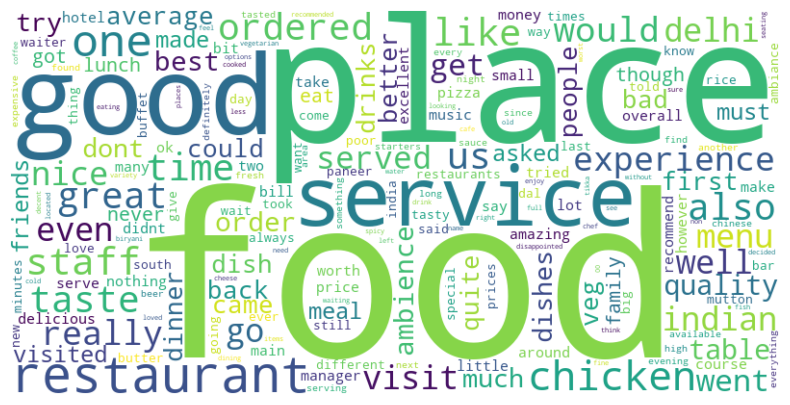

In [33]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Here we can see that in the review section, the frequency of words such as food and good are having maximum frequency. We can do the same for the review of every type of rating. Let’s see how these word clouds will look like.

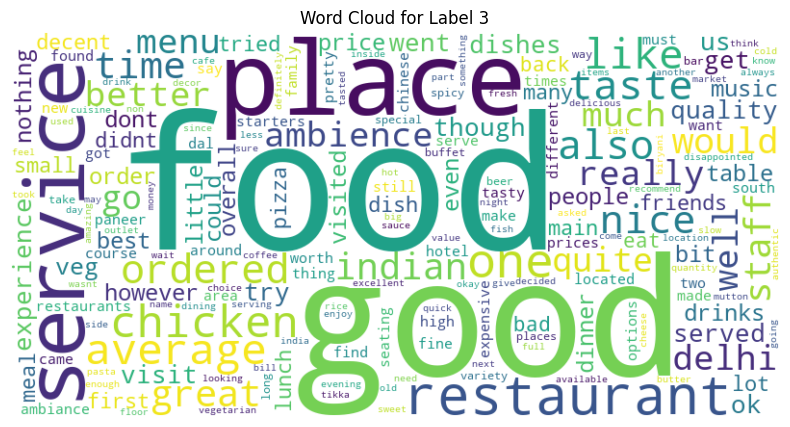

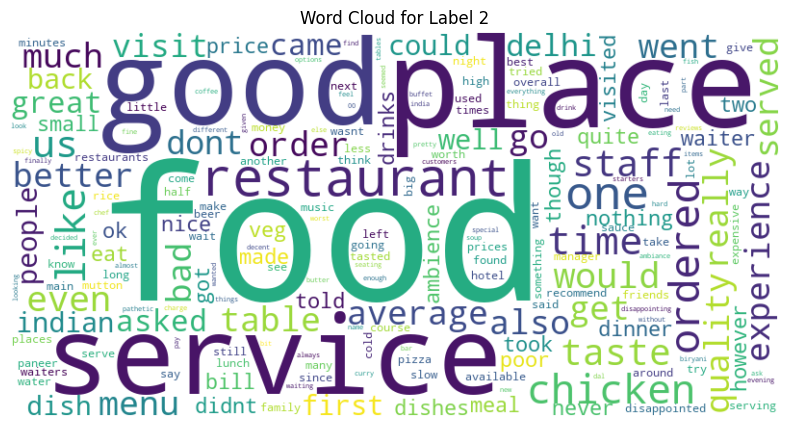

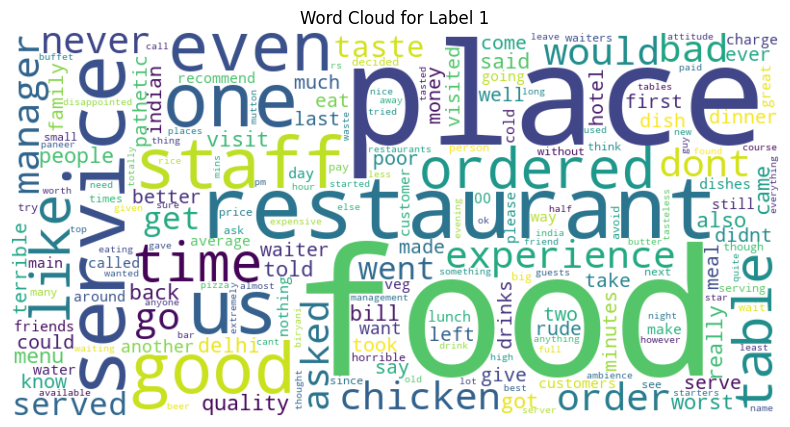

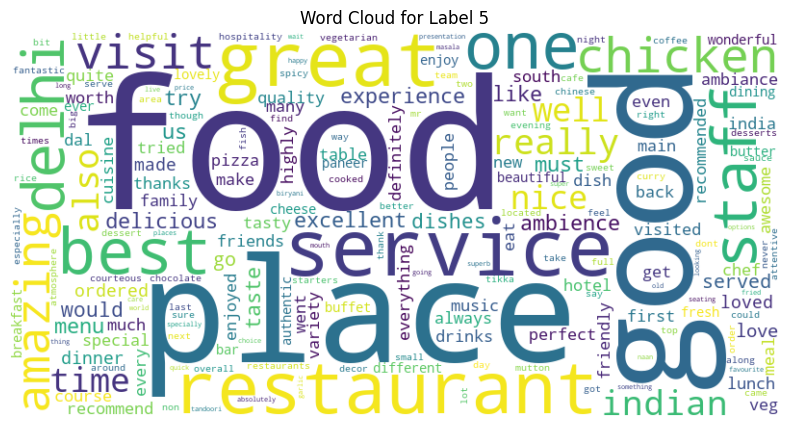

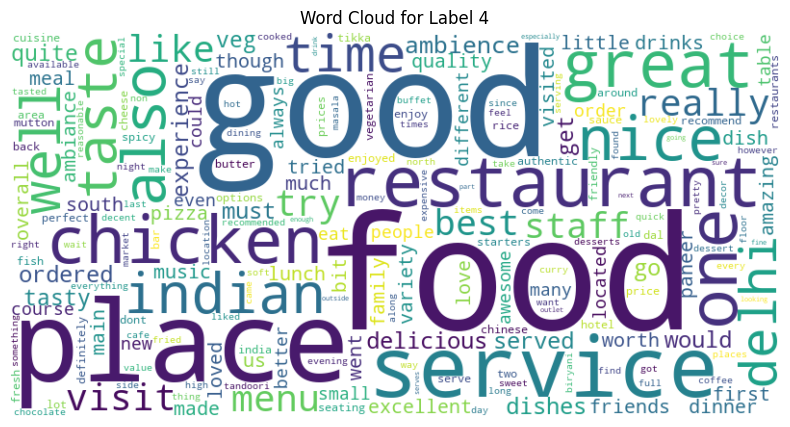

In [37]:
label_word_freq = {}
vectorizer = CountVectorizer(max_features=1000)
for label in balanced_data['rating_review'].unique():
    comments = balanced_data[balanced_data['rating_review'] == label]['cleaned_review_full']
    X = vectorizer.fit_transform(comments)
    word_freq = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))
    label_word_freq[label] = word_freq
for label, word_freq in label_word_freq.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Label {label}")
    plt.axis('off')
    plt.show()

# Data modelling

## Data processing

Here we will split our data into train and test sets so that using one, we can train the naive Bayes algorithm in data, and by using the test set, we can evaluate the model.

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(balanced_data['cleaned_review_full'], balanced_data['rating_review'], test_size=0.2, random_state=42)

Since here we are working with the text data, we need to convert the data into a sparse matrix. We can perform this using the following codes.

In [39]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

## Model Training

In [40]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()

Now we can fit the data into the model object.

In [41]:
classifier.fit(X_train, y_train)

MultinomialNB()

After this, we can make predictions from the model and move ahead for the model evaluation.



In [42]:
y_pred = classifier.predict(X_test)
print(y_pred)

[5 5 4 ... 5 4 5]


## Model Evaluation

After making some predictions, we can start our machine learning model evaluation. In this article, we will e using two ways to evaluate the model; one is we will check the accuracy of the model using the below code:

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

The second way to evaluate the model is the confusion matrix which can exactly tell us about the number of right and wrong predictions from the model.



In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=[i for i in range(5)], columns=[i for i in range(5)])
cm_df

,0,1,2,3,4
0,4778,618,294,56,34
1,654,4323,782,147,28
2,265,677,3734,930,184
3,74,222,1152,3244,1381
4,57,120,328,1655,3779


Here we can see that our model’s prediction on test data is mostly accurate, and in the above also, we can see that the model accuracy is around 67%.

We can also plot our confusion matrix to get the performance overview of the model.

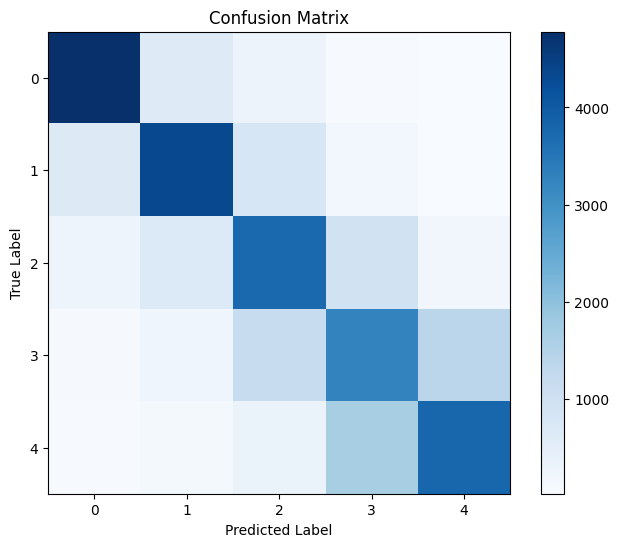

In [44]:
plt.figure(figsize=(8, 6))
plt.imshow(cm_df, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(cm_df.columns))
plt.xticks(tick_marks, cm_df.columns)
plt.yticks(tick_marks, cm_df.index)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()